In [1]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
import findspark
findspark.init()

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from pyspark import SparkContext
from pyspark.conf import SparkConf

from pyspark.sql import SparkSession
from pyspark.sql import types 
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
from pyspark.sql.functions import split, regexp_extract
from pyspark.sql.functions import isnan, isnull, when, count
from pyspark.sql.functions import to_date, dayofweek, year, month, to_timestamp

In [4]:
sc = SparkContext()
spark = SparkSession(sc)

### 1. Đọc dữ liệu => data.

In [5]:
data = spark.read.csv('../../Data/complaints.csv', header=True, inferSchema=True)

### 2. Cho biết dữ liệu có bao nhiêu dòng, in scheme. Hiển thị 3 dòng dữ liệu đầu tiên.

In [6]:
data.count()

2083368

In [7]:
data.printSchema()

root
 |-- Date received: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Sub-product: string (nullable = true)
 |-- Issue: string (nullable = true)
 |-- Sub-issue: string (nullable = true)
 |-- Consumer complaint narrative: string (nullable = true)
 |-- Company public response: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZIP code: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Consumer consent provided?: string (nullable = true)
 |-- Submitted via: string (nullable = true)
 |-- Date sent to company: string (nullable = true)
 |-- Company response to consumer: string (nullable = true)
 |-- Timely response?: string (nullable = true)
 |-- Consumer disputed?: string (nullable = true)
 |-- Complaint ID: string (nullable = true)



In [8]:
data.show(3)

+--------------------+--------------------+----------------+--------------------+--------------------+----------------------------+-----------------------+--------------------+-----+----------+--------------------+--------------------------+-------------+--------------------+----------------------------+----------------+------------------+------------+
|       Date received|             Product|     Sub-product|               Issue|           Sub-issue|Consumer complaint narrative|Company public response|             Company|State|  ZIP code|                Tags|Consumer consent provided?|Submitted via|Date sent to company|Company response to consumer|Timely response?|Consumer disputed?|Complaint ID|
+--------------------+--------------------+----------------+--------------------+--------------------+----------------------------+-----------------------+--------------------+-----+----------+--------------------+--------------------------+-------------+--------------------+--------------

### 3. Kiểm tra dữ liệu NaN, null.

In [9]:
data.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).toPandas().T

,0
Date received,0
Product,0
Sub-product,0
Issue,0
Sub-issue,0
Consumer complaint narrative,0
Company public response,0
Company,0
State,0
ZIP code,0


=> không có dữ liệu NaN

In [10]:
data.select([count(when(isnull(c), c)).alias(c) for c in data.columns]).toPandas().T

,0
Date received,40
Product,209258
Sub-product,511176
Issue,325183
Sub-issue,931248
Consumer complaint narrative,1454171
Company public response,1412034
Company,573431
State,597994
ZIP code,673059


=> Có rất nhiều dữ liệu null theo từng cột

### 4. Kiểm tra dữ liệu trùng. Xóa dữ liệu trùng.

In [11]:
num_rows = data.count()
num_dist_rows = data.distinct().count()
dup_rows = num_rows - num_dist_rows

In [12]:
num_dist_rows

2020609

In [13]:
dup_rows

62759

Có dữ liệu trùng

In [14]:
data = data.drop_duplicates()

In [15]:
data.distinct().count()

2020609

Hết dữ liệu trùng

### 5. Kiểm tra dữ liệu null. Tính tỉ lệ null.

In [16]:
null_data = data.select([count(when(isnull(c), c)).alias(c) for c in data.columns]).toPandas().T

In [17]:
null_data

,0
Date received,39
Product,178373
Sub-product,472168
Issue,281416
Sub-issue,884470
Consumer complaint narrative,1405173
Company public response,1353196
Company,513337
State,537111
ZIP code,611785


In [18]:
null_data["Percentage"] = (null_data[0]/num_dist_rows)*100

In [19]:
null_data.sort_values('Percentage', axis=0, ascending=False)

,0,Percentage
Tags,1659004,82.104158
Consumer complaint narrative,1405173,69.542054
Company public response,1353196,66.969711
Sub-issue,884470,43.772447
Complaint ID,666220,32.971248
Consumer disputed?,659883,32.657629
Timely response?,649891,32.163125
Company response to consumer,632256,31.290368
ZIP code,611785,30.277258
Date sent to company,597981,29.594098


### 6. Tạo dữ liệu mới, trong đó không có các cột có dữ liệu thiếu trên 30%.

In [20]:
cols = null_data[null_data['Percentage'] < 30].index.values.tolist()

In [21]:
cols

['Date received',
 'Product',
 'Sub-product',
 'Issue',
 'Company',
 'State',
 'Consumer consent provided?',
 'Submitted via',
 'Date sent to company']

In [22]:
data_sub = data.select(cols)

In [23]:
data_sub.show(2)

+--------------------+--------------------+-----------+-----+-------+-----+--------------------------+-------------+--------------------+
|       Date received|             Product|Sub-product|Issue|Company|State|Consumer consent provided?|Submitted via|Date sent to company|
+--------------------+--------------------+-----------+-----+-------+-----+--------------------------+-------------+--------------------+
|****United XXXXXX...| 12 CFR 1024.17 (...|       null| null|   null| null|                      null|         null|                null|
|**See attached 1s...|                null|       null| null|   null| null|                      null|         null|                null|
+--------------------+--------------------+-----------+-----+-------+-----+--------------------------+-------------+--------------------+
only showing top 2 rows



### 7. Xóa các dòng có 'Date recieved' là null và/hoặc 'Product' là null.

In [24]:
data_sub = data_sub.dropna(how='any', subset=['Date received','Product'])

In [25]:
data_sub.select([count(when(isnull(c), c)).alias(c) for c in data_sub.columns]).toPandas().T

,0
Date received,0
Product,0
Sub-product,332225
Issue,141159
Company,373348
State,397120
Consumer consent provided?,399331
Submitted via,381799
Date sent to company,419608


### 8. Tạo cột 'date_from_text' chứa dữ liệu yyyy-dd-mm từ 'Date recieved' nếu có, nếu không sẽ là ''. Lọc dữ liệu data_sub với yêu cầu 'date_from_text' khác ''.

In [26]:
data_sub = data_sub.withColumn('date_from_text', regexp_extract(data_sub['Date received'], r"(\d{4}-\d{1,2}-\d{1,2})", 0))

In [27]:
data_sub.select('date_from_text', 'Date received').head(5)

[Row(date_from_text='', Date received='****United XXXXXXXX XXXX and XXXX XXXX XXXX dba XXXX XXXX clearly violated Regulation X'),
 Row(date_from_text='', Date received='- was informed that the 2nd settlement agreement created on XX/XX/XXXX'),
 Row(date_from_text='', Date received='13. Finally'),
 Row(date_from_text='', Date received='4.Please send this information to my address listed above and accept this formal complaint asmy formal debt validation request'),
 Row(date_from_text='', Date received='Also')]

In [28]:
data_sub = data_sub.filter(data_sub['date_from_text'] != '')

In [29]:
data_sub.select('date_from_text', 'Date received').head(10)

[Row(date_from_text='2019-02-28', Date received='2019-02-28'),
 Row(date_from_text='2019-06-07', Date received='2019-06-07'),
 Row(date_from_text='2019-05-20', Date received='2019-05-20'),
 Row(date_from_text='2019-02-15', Date received='2019-02-15'),
 Row(date_from_text='2019-08-03', Date received='2019-08-03'),
 Row(date_from_text='2019-04-05', Date received='2019-04-05'),
 Row(date_from_text='2019-05-04', Date received='2019-05-04'),
 Row(date_from_text='2019-06-06', Date received='2019-06-06'),
 Row(date_from_text='2019-03-18', Date received='2019-03-18'),
 Row(date_from_text='2019-01-15', Date received='2019-01-15')]

### 9. Tạo cột 'CCP' mới lấy dữ liệu từ cột 'Consumer consent provided?'. Với cột 'CCP' hãy điền 'Consent not provided' thay cho null.

In [30]:
data_sub = data_sub.withColumn('CCP', data_sub['Consumer consent provided?'])

In [31]:
data_sub = data_sub.fillna('Consent not provided', subset='CCP')

### 10. Tạo cột 'SV' mới lấy dữ liệu từ cột 'Submitted via'. Với cột 'SV' hãy điền 'Other' thay cho null.

In [32]:
data_sub = data_sub.withColumn('SV', data_sub['Submitted via'])

In [33]:
data_sub = data_sub.fillna('Other', subset='SV')

### 11. Tạo cột 'Sub-pr' mới lấy dữ liệu từ cột 'Sub-product'. Với cột 'Sub-pr' hãy điền 'I do not know' thay cho null.

In [34]:
data_sub = data_sub.withColumn('Sub-pr', data_sub['Sub-product'])

In [35]:
data_sub = data_sub.fillna('I do not know', subset='Sub-pr')

In [36]:
data_sub.select([count(when(isnull(c), c)).alias(c) for c in data_sub.columns]).toPandas().T

,0
Date received,0
Product,0
Sub-product,234541
Issue,0
Company,147497
State,173009
Consumer consent provided?,174052
Submitted via,156052
Date sent to company,155134
date_from_text,0


### 12. Tạo cột 'State_new' lấy dữ liệu từ cột 'State' theo điều kiện sau: nếu có thông tin State thì lấy thông tin, nếu không có thông tin thì điền 'unknow' thay cho null.

In [37]:
data_sub = data_sub.withColumn('State_new', when(col('State').isNull(), 'unknow').otherwise(col('State')))

### 13. Tạo cột 'Date_received' lấy dữ liệu từ cột 'date_from_text', định dạng thời gian yyyy-mm-dd.

In [38]:
func = udf(lambda x: datetime.strptime(x, '%Y-%m-%d'), DateType())
data_sub = data_sub.withColumn('Date_received', func(col('date_from_text')))

In [39]:
data_sub.printSchema()

root
 |-- Date received: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Sub-product: string (nullable = true)
 |-- Issue: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Consumer consent provided?: string (nullable = true)
 |-- Submitted via: string (nullable = true)
 |-- Date sent to company: string (nullable = true)
 |-- date_from_text: string (nullable = true)
 |-- CCP: string (nullable = false)
 |-- SV: string (nullable = false)
 |-- Sub-pr: string (nullable = false)
 |-- State_new: string (nullable = true)
 |-- Date_received: date (nullable = true)



In [40]:
data_sub.select('Date_received').show(5)

+-------------+
|Date_received|
+-------------+
|   2019-02-28|
|   2019-06-07|
|   2019-05-20|
|   2019-02-15|
|   2019-08-03|
+-------------+
only showing top 5 rows



### 14. Tạo cột mới chứa ngày trong tuần 'day_of_week'(1: Monday, 7:Sunday) với lấy dữ liệu từ cột 'Date_received'.

In [41]:
data_sub = data_sub.withColumn('day_of_week', dayofweek('Date_received'))

### 15. Tạo cột year, month, chứa năm, tháng với dữ liệu lấy từ cột 'Date_received'.

In [42]:
data_sub = data_sub.withColumn('year', year('Date_received')).withColumn('month', month('Date_received'))

In [43]:
data_sub.select('Date_received', 'day_of_week', 'year', 'month').show(5)

+-------------+-----------+----+-----+
|Date_received|day_of_week|year|month|
+-------------+-----------+----+-----+
|   2019-02-28|          5|2019|    2|
|   2019-06-07|          6|2019|    6|
|   2019-05-20|          2|2019|    5|
|   2019-02-15|          6|2019|    2|
|   2019-08-03|          7|2019|    8|
+-------------+-----------+----+-----+
only showing top 5 rows



In [44]:
data_sub.select([count(when(isnull(c), c)).alias(c) for c in data_sub.columns]).toPandas().T

,0
Date received,0
Product,0
Sub-product,234541
Issue,0
Company,147497
State,173009
Consumer consent provided?,174052
Submitted via,156052
Date sent to company,155134
date_from_text,0


### 16. Vẽ biểu đồ thể hiện tần suất nhận complaint theo ngày trong tuần.

In [45]:
df = data_sub.select('day_of_week').toPandas()

array([[<AxesSubplot:title={'center':'day_of_week'}>]], dtype=object)

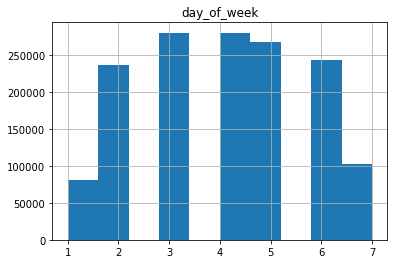

In [46]:
df.hist()

### 17. Hãy cho biết 20 sản phẩm nhận complaint nhiều nhất. Đó là những sản phẩm nào? Biểu diễn bằng đồ thị.

In [47]:
df_products = data_sub.groupby('product').count().orderBy('count', ascending=False).toPandas()

In [48]:
df_products.head(20)

,product,count
0,"Credit reporting, credit repair services, or o...",331635
1,Mortgage,295097
2,Debt collection,278961
3,Credit reporting,139825
4,Credit card,89175
5,Bank account or service,86193
6,Credit card or prepaid card,67849
7,Checking or savings account,57461
8,Student loan,56365
9,Consumer Loan,31592


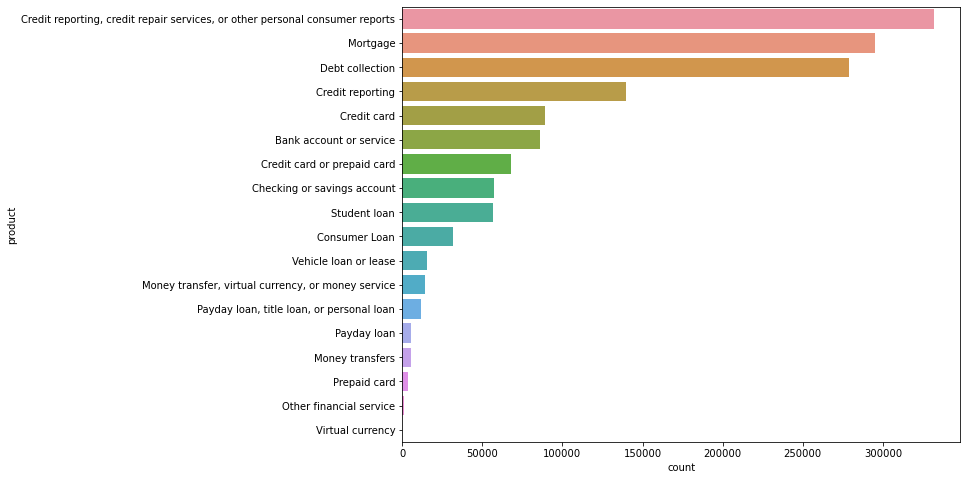

In [49]:
plt.figure(figsize=(10, 8))
sns.barplot(data=df_products, x='count', y='product')
plt.show()